# Modeling a flock of active nematics
Requires Python>=3.7  
Before running, copy or move the cytosim module (cytosim.---.so) to the current folder.
```bash
$ make -j4 pycytosim
$ cp bin/*.so examples/
```
Here we showcase the addition of forces and dynamic simulation control.

In [1]:
import cytosim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_sim(sim):
    """ A function to plot the simulation state"""
    space = sim.findSpace("cell")
    radius = space.max_extension()
    plt.figure()
    r = np.linspace(0,2.0*np.pi,100)
    plt.plot(radius* np.cos(r),radius*np.sin(r),color="black")
    for fiber in sim.fibers:
        p = fiber.points()
        plt.plot(p[:,0],p[:,1])
        plt.scatter(p[1,0],p[1,1])
    
    plt.axis('equal')
    plt.show()
    

## Repulsion between fish
Here we simulate two fibers.

In [3]:
parser = cytosim.start("flock.cym")
sim = parser.simul

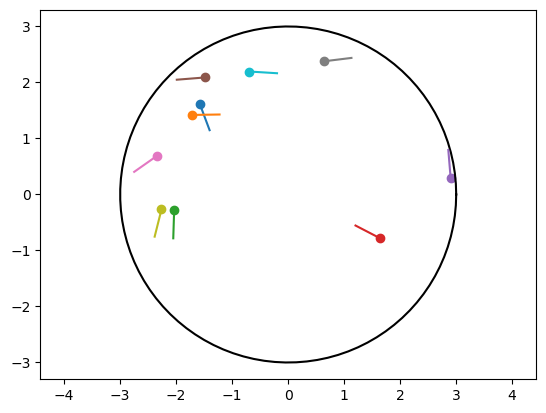

In [4]:
# Running 10 frames of 20 time steps
for k in range(10):
    parser.run(20)
    parser.save()
plot_sim(sim)

## Adding attractive interactions 
First we identify the (interpolated) center points of fibers, then we add different forces to them.

In [5]:
def get_norm_sqr(vec):
    return np.sum(np.square(vec))

In [6]:
# A function to add attractive forces to fibers
def add_attractive(sim):
    """ Adds attractive interactions between fibers """
    pot = 0.1
    min_dist_sqr = 0.05
    meca = sim.sMeca
    # iterating over all fibers
    for i,fish in enumerate(sim.fibers):
        pt1 =fish.interpolateCenter()
        pos1 = pt1.pos()
        for j,f in enumerate(sim.fibers):
            # one interaction per fiber pair
            if j>i:
                pt2 = f.interpolateCenter()
                pos2 = pt2.pos()
                r2 = get_norm_sqr(pos2-pos1)
                stiff = (1.0-np.exp(-r2/min_dist_sqr))*pot/r2 # does not diverge
                meca.addLink(pt1,pt2,stiff)

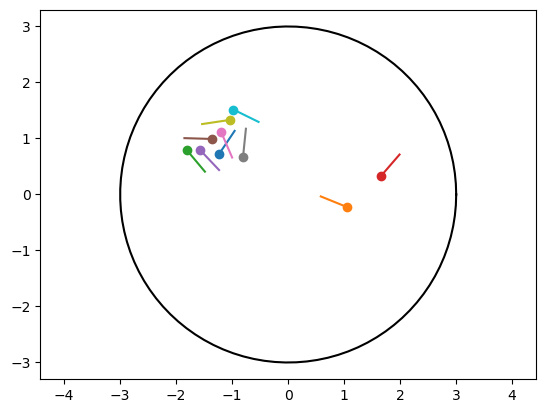

In [7]:
# Running 30 frames of 20 time steps
for k in range(30):
    for s in range(20):
        sim.step()
        sim.prepare_meca()
        add_attractive(sim)
        sim.prepared_solve()
    parser.save()
    
plot_sim(sim)

In [8]:
def add_alignement(sim):
    """ Adds alignement interactions between fibers """
    pot = 0.01
    meca = sim.sMeca
    # interacting over all fibers
    for i,fish in enumerate(sim.fibers):
        pt1 =fish.interpolateCenter()
        pos1 = pt1.pos()
        # one interaction per fiber pair
        for j,f in enumerate(sim.fibers):
            if j>i:
                pt2 = f.interpolateCenter()
                pos2 = pt2.pos()
                r2 = get_norm_sqr(pos2-pos1)
                meca.addTorqueParrallel(pt1,pt2,pot/r2)


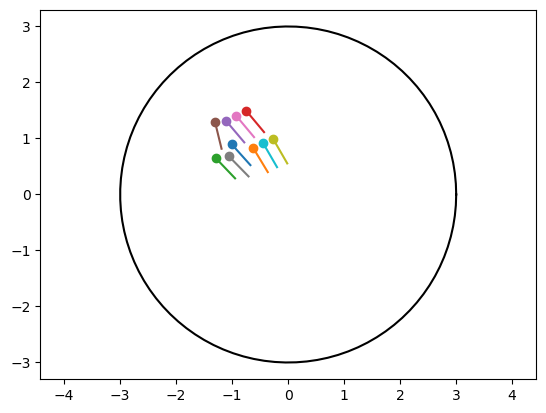

In [9]:
# Running 30 frames of 20 time steps
for k in range(30):
    for s in range(20):
        sim.step()
        sim.prepare_meca()
        add_attractive(sim)
        add_alignement(sim)
        sim.prepared_solve()
    parser.save()
    
plot_sim(sim)

### Adding movement
We add a point foce to the fiber center

In [10]:
def add_movement(sim):
    """ Adds a force in the direction of the fiber """
    force = 0.05
    meca = sim.sMeca
    for fish in sim.fibers:
        pt1 =fish.interpolateCenter()
        dir = pt1.dir()
        meca.addForce(pt1,dir*force)

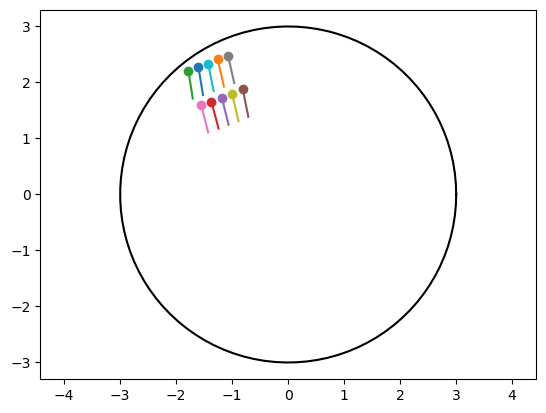

In [11]:
# Running 180 frames of 20 time steps
for k in range(180):
    for s in range(20):
        sim.step()
        sim.prepare_meca()
        add_attractive(sim)
        add_alignement(sim)
        add_movement(sim)
        sim.prepared_solve()
    parser.save()
    
plot_sim(sim)